# Exercise: Monte Carlo

Monte Carlo methods may be familiar from earlier years, where stochastic (random) processes are used to find, for example, the minimum energy position of some atom in space. 
Here we will look at using Monte Carlo to improve our model fitting methods, in particular the quantification of the uncertainties on the model parameters. 

In the [model fitting](https://pythoninchemistry.org/ch40208/working_with_data/curve_fitting.html) section, you were shown how the `curve_fit` function can get estimations of these inverse uncertainties (a fancy name for the parameter uncertainties in the model). 
However, these uncertainties are only estimates and are based on assumptions about the fitting process (the particular assumptions made are beyond the scope of this course). 
Therefore, we will use a stochastic method to more completely probe these uncertainties.

For this problem we are going to look at the investigation of a mixture of organic species by IR spectroscopy. 
We have been given [this data set](https://pythoninchemistry.org/ch40208/working_with_data/mixture.csv), and are told it contains a mixture of toluene and benzyl alcohol. 
> Use the `!head` command to investigate the experimental data file and plot the data using the [`plt.errorbar`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.errorbar.html) function. 

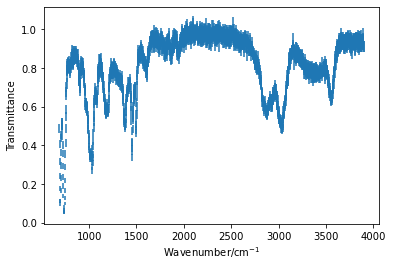

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mixture = np.loadtxt('mixture.csv', unpack=True, delimiter=',')
plt.errorbar(mixture[0], mixture[1], mixture[2], marker='', ls='')
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

## Our model

The aim of this exercise is to determine the relative concentration of toluene and benzyl alcohol that make up the mixture data that you have just plotted. 
In order to achieve this, it is necessary that we define a model to describe this data. 
The transmittance data from the mixture ($T_{\text{mix}}$) is made up of transmittance data from toluene ($T_{\text{t}}$) and benzyl alcohol ($T_{\text{b}}$), and nothing else. 
Since we are interested in the **relative** concentration, we can describe this as fraction of the composition and sicne the transmittances are additive, we can define the following model.

$$T_{\text{mix}} = cT_{\text{t}} + (1 - c)T_{\text{b}}, $$

where $c$ describes the composition of the mixture and is the single parameter in our model.
> Write a function for the above model, `c` should be the first argument as this is the variable parameter we are investigating. Other arguments should include the transmittance from the pure samples.

In [2]:
def my_model(c, T_t, T_b):
    """
    Compositional model for the mixture.
    
    Args:
        c (float): composition parameter.
        T_t (array_like): transmittance from toluene.
        T_b (array_like): transmittance from benzyl alcohol.
        
    Returns:
        (array_like): model mixture transmittance.
    """
    return c * T_t + (1 - c) * T_b

We don't yet have IR spectra for the pure samples that we can use in the above model. 
Files for these spectra are available [here for toluene](https://pythoninchemistry.org/ch40208/working_with_data/toluene.csv) and [here for benzyl alcohol](https://pythoninchemistry.org/ch40208/working_with_data/benzyl_alcohol.csv).
> Read in and plot each of the pure datasets. 

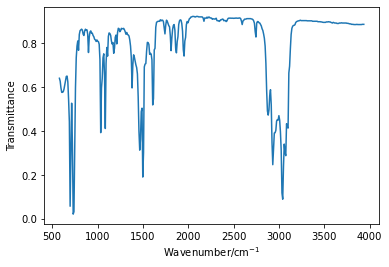

In [3]:
toluene = np.loadtxt('toluene.csv', unpack=True, delimiter=',')
plt.plot(toluene[0], toluene[1], '-')
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

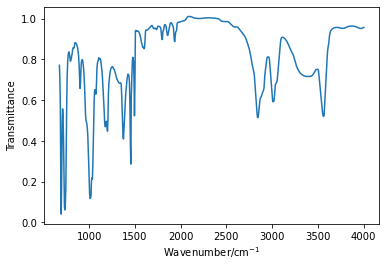

In [4]:
benzyl = np.loadtxt('benzyl_alcohol.csv', unpack=True, delimiter=',')
plt.plot(benzyl[0], benzyl[1], '-')
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

## Interpolation

You will have noticed that the *x*-axis on each of the three plots created so far do not cover the same range. 
However, in order to accurately use the model outline above, the transmittance values for all three IR spectra should be at the same wavenumbers. 
Therefore, it is necessary that we interpolate the two pure datasets such that the wavenumber values are the same as for the mixture. 

Interpolation is where we determine new data points within the range of a discrete set of known points. 
Essentially, we use what we know about the *x*- and *y*-values to determine the *y*-values for a different set of *x*-values. 
It is important that the new range of *x*-values is from within the existing range, or else we are extrapolating (which is often unscientific). 
In the three datasets that you have, the two pure samples both have broader ranges than the mixture. 
Therefore, we will use the *x*-values for the mixture and extrapolate new *y*-values for each of the pure samples.

For interpolation, we can use the [`np.interp`](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) method. 
This method takes three arguments, `x` the new *x*-axis, `xp` the old *x*-axis, and `fp` the old *y*-axis. 
It will return a new set of *y*-values.
> Interpolate transmittance values for the two model IR spectra and plot these over the original data to check that they agree. 

In [5]:
toluene_o = np.copy(toluene)
benzyl_o = np.copy(benzyl)

In [15]:
toluene = np.zeros((2, len(mixture[2])))
benzyl = np.zeros((2, len(mixture[2])))

The `np.copy` function simply makes a duplicate of the array.
While the `np.zeros` function returns an array containing all zeros of a given shape.

In [18]:
toluene[0] = mixture[0]
toluene[1] = np.interp(mixture[0], toluene_o[0], toluene_o[1])

In [19]:
benzyl[0] = mixture[0]
benzyl[1] = np.interp(mixture[0], benzyl_o[0], benzyl_o[1])

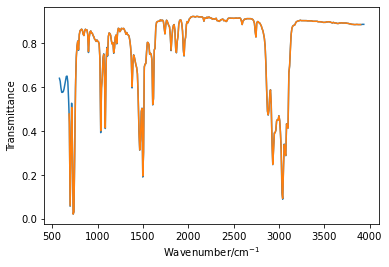

In [20]:
plt.plot(toluene_o[0], toluene_o[1], '-')
plt.plot(toluene[0], toluene[1], '-')
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

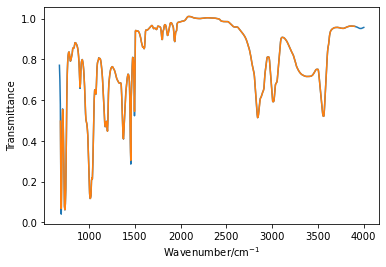

In [21]:
plt.plot(benzyl_o[0], benzyl_o[1], '-')
plt.plot(benzyl[0], benzyl[1], '-')
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

## A *rough* guess

Now that we have the pure data read in and on the correct *x*-axis, we can test the model that we created earlier. 
> Generate the model transmittance data that would arise from a 50:50 mixture of the two components. 
> Plot this data on top of the mixture data and see if it agrees visually. 

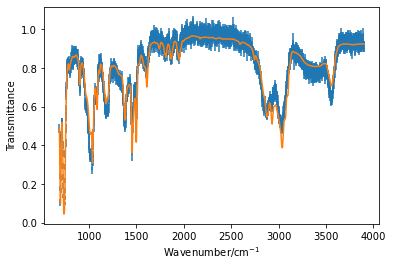

In [22]:
plt.errorbar(*mixture, ls='', marker='')
plt.plot(mixture[0], my_model(0.5, toluene[1], benzyl[1]))
plt.xlabel('Wavenumber/cm$^{-1}$')
plt.ylabel('Transmittance')
plt.show()

Now that our model is working, we can use the methodology introduced previously to minimise the difference between our model and the data. 
> Write a chi-squared function and minimise this using the `scipy.optimize.minimize` function. This will give an optimised value for `c`. 

In [23]:
def chi_squared(c, T_t, T_b, T_m, dT_m):
    """
    Determine the chi-squared value for a first-order rate equation.
    
    Args:
        x (list): The variable parameters.
        t (float): Time (s).
        data (float): Experimental concentration data.
    
    Returns:
        (float): chi^2 value.
    """
    return np.sum(((T_m - my_model(c, T_t, T_b)) ** 2) / (dT_m) ** 2)

In [24]:
from scipy.optimize import minimize

In [25]:
result = minimize(chi_squared, [0.5], args=(toluene[1], benzyl[1], mixture[1], mixture[2]))

In [26]:
print(result.x)

[0.32253315]


## Sampling

Having found the optimised value for the concentration, we can now use a modification of a Monte Carlo process to sample the uncertainty in this concentration parameter. 
This methodology is called Markov chain Monte Carlo (MCMC), it involves starting from some value and then changing the value by some small random amount with each iteration. 
The fact that the next parameter value depends on the previous one makes the sampling a Markov chain, while the use of random pertubations is Monte Carlo. 

In MCMC we start from an initial value, usually found by obtaining an optimised solution.
This initial value is changed by some random amount ($\delta$), which is obtained based on some defined. step size ($s$) change with respect to the variable ($v$), 

$$ \delta = Nsv, $$

where $N$ is some random number, obtained from a normal distribution centred on 0 with a standard deviation of 1. 
In Python, $R$ can be obtained with the function `np.random.randn()`.
We then determine if this random perturbation has improved the. agreement to the data or not. 
If it has, we accept this new value for our variable ($v + \delta$) and perform anouther perturbation. 
If this perturbation does not improve agreement with the data, the new value is not immediately rejects, rather it is only rejected if the probability of this transition ($p$) is less than some random number from 0 to 1 (this time we use `np.random.random()` to obtain such a number). 
The probability is found by, 

$$p = \exp\Bigg(\frac{-\chi^2_{\text{new}} + \chi^2}{2}\Bigg), $$

where $\chi^2$ is the original goodness of fit and  $\chi^2_{\text{new}}$ is the goodness of fit after the pertubation.
This means that it is possible for the agrement to get worse overtime. 
However, the amount by which is can get worse is controled by the probability. 
The result of this is that the values of our Markov chain that are accepted will describe the statistically feasible value for our parameter given the uncertainty in the experimental measurements.  

The algorithm for a typical MCMC sampling process is as follows: 
1. Create an empty list for the accepted values
2. Evaluate $\chi^2$ for the initial guess, typically this initial guess will be the optimised solution. 
3. Perturb the parameter value ($v + \delta$)
4. Calculate $\chi^2_{\text{new}}$ for the perturbed value
5. Determine the probability of this transition
6. Check that $p\geq R$, where $R$ is a random number from 0 to 1, if the new $\chi^2$ is less than the old one, then $p>1$ and therefore always accepted
7. If true, updated the values of $v$ and $\chi^2$, and append $v$ to the accepted values list
8. Go to step 3 and repeat until the desired number of iterations have been achieved.

> Write a function to perform the MCMC alogrithm outlined above, this should take a number of iterations (this should be no more than 2000) and a step size as arguments and return the list of accepted values. 
> Plot a histogram of the accepted values (using `plt.hist`), these should be normally distributed (you may need to google to see what this looks like).
> Vary the step size between 1 and 0.001 to get the most normally distributed data you can. 
> Using the statistical function in NumPy, calculate the mean and standard deviation of this distribution. 

In [27]:
def mcmc(iterations, step_size):
    """
    The MCMC algorithm.
    
    Args:
        iterations (int): number of draws to make.
        step_size (float): the control parameter for the Markov chain step.
    
    Returns:    
        (array_like): The accepted values.
    """
    c = result.x[0]

    accepted = []
    chi_s =  chi_squared(c, toluene[1], benzyl[1], mixture[1], mixture[2])
    for i in range(0, iterations):
        perturbation = step_size * np.random.randn() * c
        new_c = c + perturbation
        new_chi_s =  chi_squared(new_c, toluene[1], benzyl[1], mixture[1], mixture[2])
        p = np.exp((-new_chi_s + chi_s) / 2)
        n = np.random.random()
        if n < p:
            c = new_c
            chi_s = new_chi_s
            accepted.append(c)
    return accepted

In [28]:
accepted = mcmc(2000, 0.01)

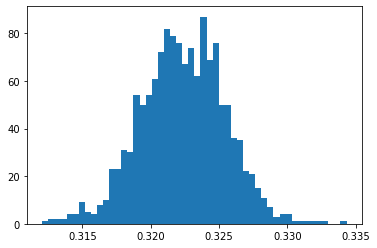

In [29]:
plt.hist(accepted, bins=50)
plt.show()

In [30]:
np.mean(accepted), np.std(accepted)

(0.3223480082470147, 0.003089678924183351)